# Python实现随机森林
在这个笔记本中，我们将用Python实现一个随机森林。使用Python中的机器学习，很容易建立一个复杂的模型而无需知道它是如何工作的。因此，我们将从一棵决策树和一个简单的问题开始，然后再到随机森林和一个真实世界的问题。
一旦我们理解了一棵决策树是如何思考的，我们就可以将这些知识转移到整个树的森林中。

In [24]:
import numpy as np
import pandas as pd

# 设置随机种子以确保可重复性
RSEED = 50

# 从简单的基本问题开始
首先，我们将使用一个非常简单的问题，只有两个特征和两个类别。这是一个二元分类问题。
我们先创建特征`X`和标签`y`。只有两个特征，这将使我们能够将数据可视化，这使得这个问题非常简单。

In [25]:
X = np.array([[2, 2], 
              [2, 1],
              [2, 3], 
              [1, 2], 
              [1, 1],
              [3, 3]])

y = np.array([0, 1, 1, 1, 0, 1])

### 数据可视化
为了了解数据，我们可以将数据点与显示标签的数字作图。

Text(0.5, 1.0, 'Data')

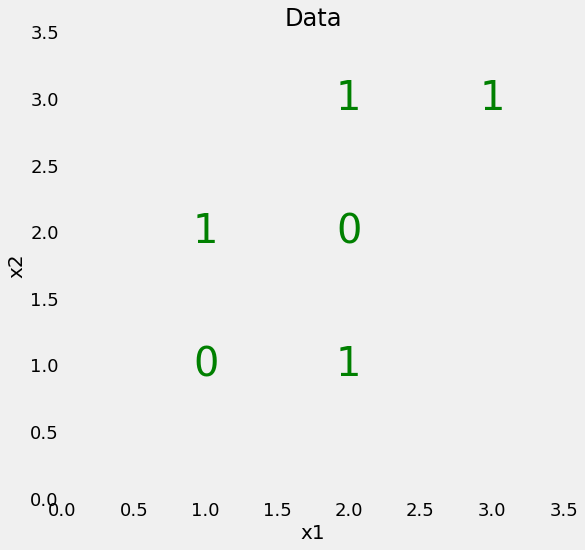

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.figure(figsize = (8, 8))

# Plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((0, 3.5));
plt.ylim((0, 3.5));
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Data', size = 24)

即使只有两个特征，这也是一个线性不可分割的问题。一个简单的线性分类器将无法画出一个分离类的边界。单一的决策树将能够完全分开这些点，因为它基本上在各点之间画出许多重复的线性边界。决策树是一个非参数模型，因为参数的数量会随着数据的大小而增长。

## 单决策树

在这里，我们使用Scikit-Learn在数据上快速建立和训练一棵决策树。该树将学习如何分离点，根据特征值和标签建立一个问题的流程图。在每个阶段，决策树通过最大限度地减少吉尼不纯度来进行分割。  

我们将对决策树使用默认的超参数，这意味着它可以根据需要增长到最深的程度，以便完全分离类别。这将导致过度拟合，因为模型会记忆训练数据，而在实践中，我们通常希望限制树的深度，以便它能概括到测试数据。

In [27]:
from sklearn.tree import DecisionTreeClassifier

# 生成决策树并训练
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(X, y)

DecisionTreeClassifier(random_state=50)

In [28]:
print(f'决策树有 {tree.tree_.node_count} 个节点， 最大深度为 {tree.tree_.max_depth}.')

决策树有 9 个节点， 最大深度为 3.


我们的决策树形成了9个节点，最大深度达到了3。它在训练数据上将达到100%的准确率，因为我们没有限制深度，因此它可以对每个训练点进行完美分类。

In [29]:
print(f'模型准确率 Accuracy: {tree.score(X, y)}')

模型准确率 Accuracy: 1.0


## 可视化决策树

为了了解决策树如何 "思考"，将整个结构可视化是有帮助的。这将显示树上的每个节点，我们可以用它来做新的预测。因为树相对较小，我们可以了解整个图像。

首先，我们将树导出为`dot`文件，确保标记特征和类别。

In [30]:
from sklearn.tree import export_graphviz

# Export as dot
export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

接下来我们使用系统cmd命令和Graphziv的`dot`函数来转换为`png`（图片）。这需要在你的电脑上安装**Graphviz**。

In [31]:
import os
cmd = 'dot -Tpng tree.dot -o tree.png -Gdpi=400'
os.system(cmd)

0

最后，我们显示整个树。

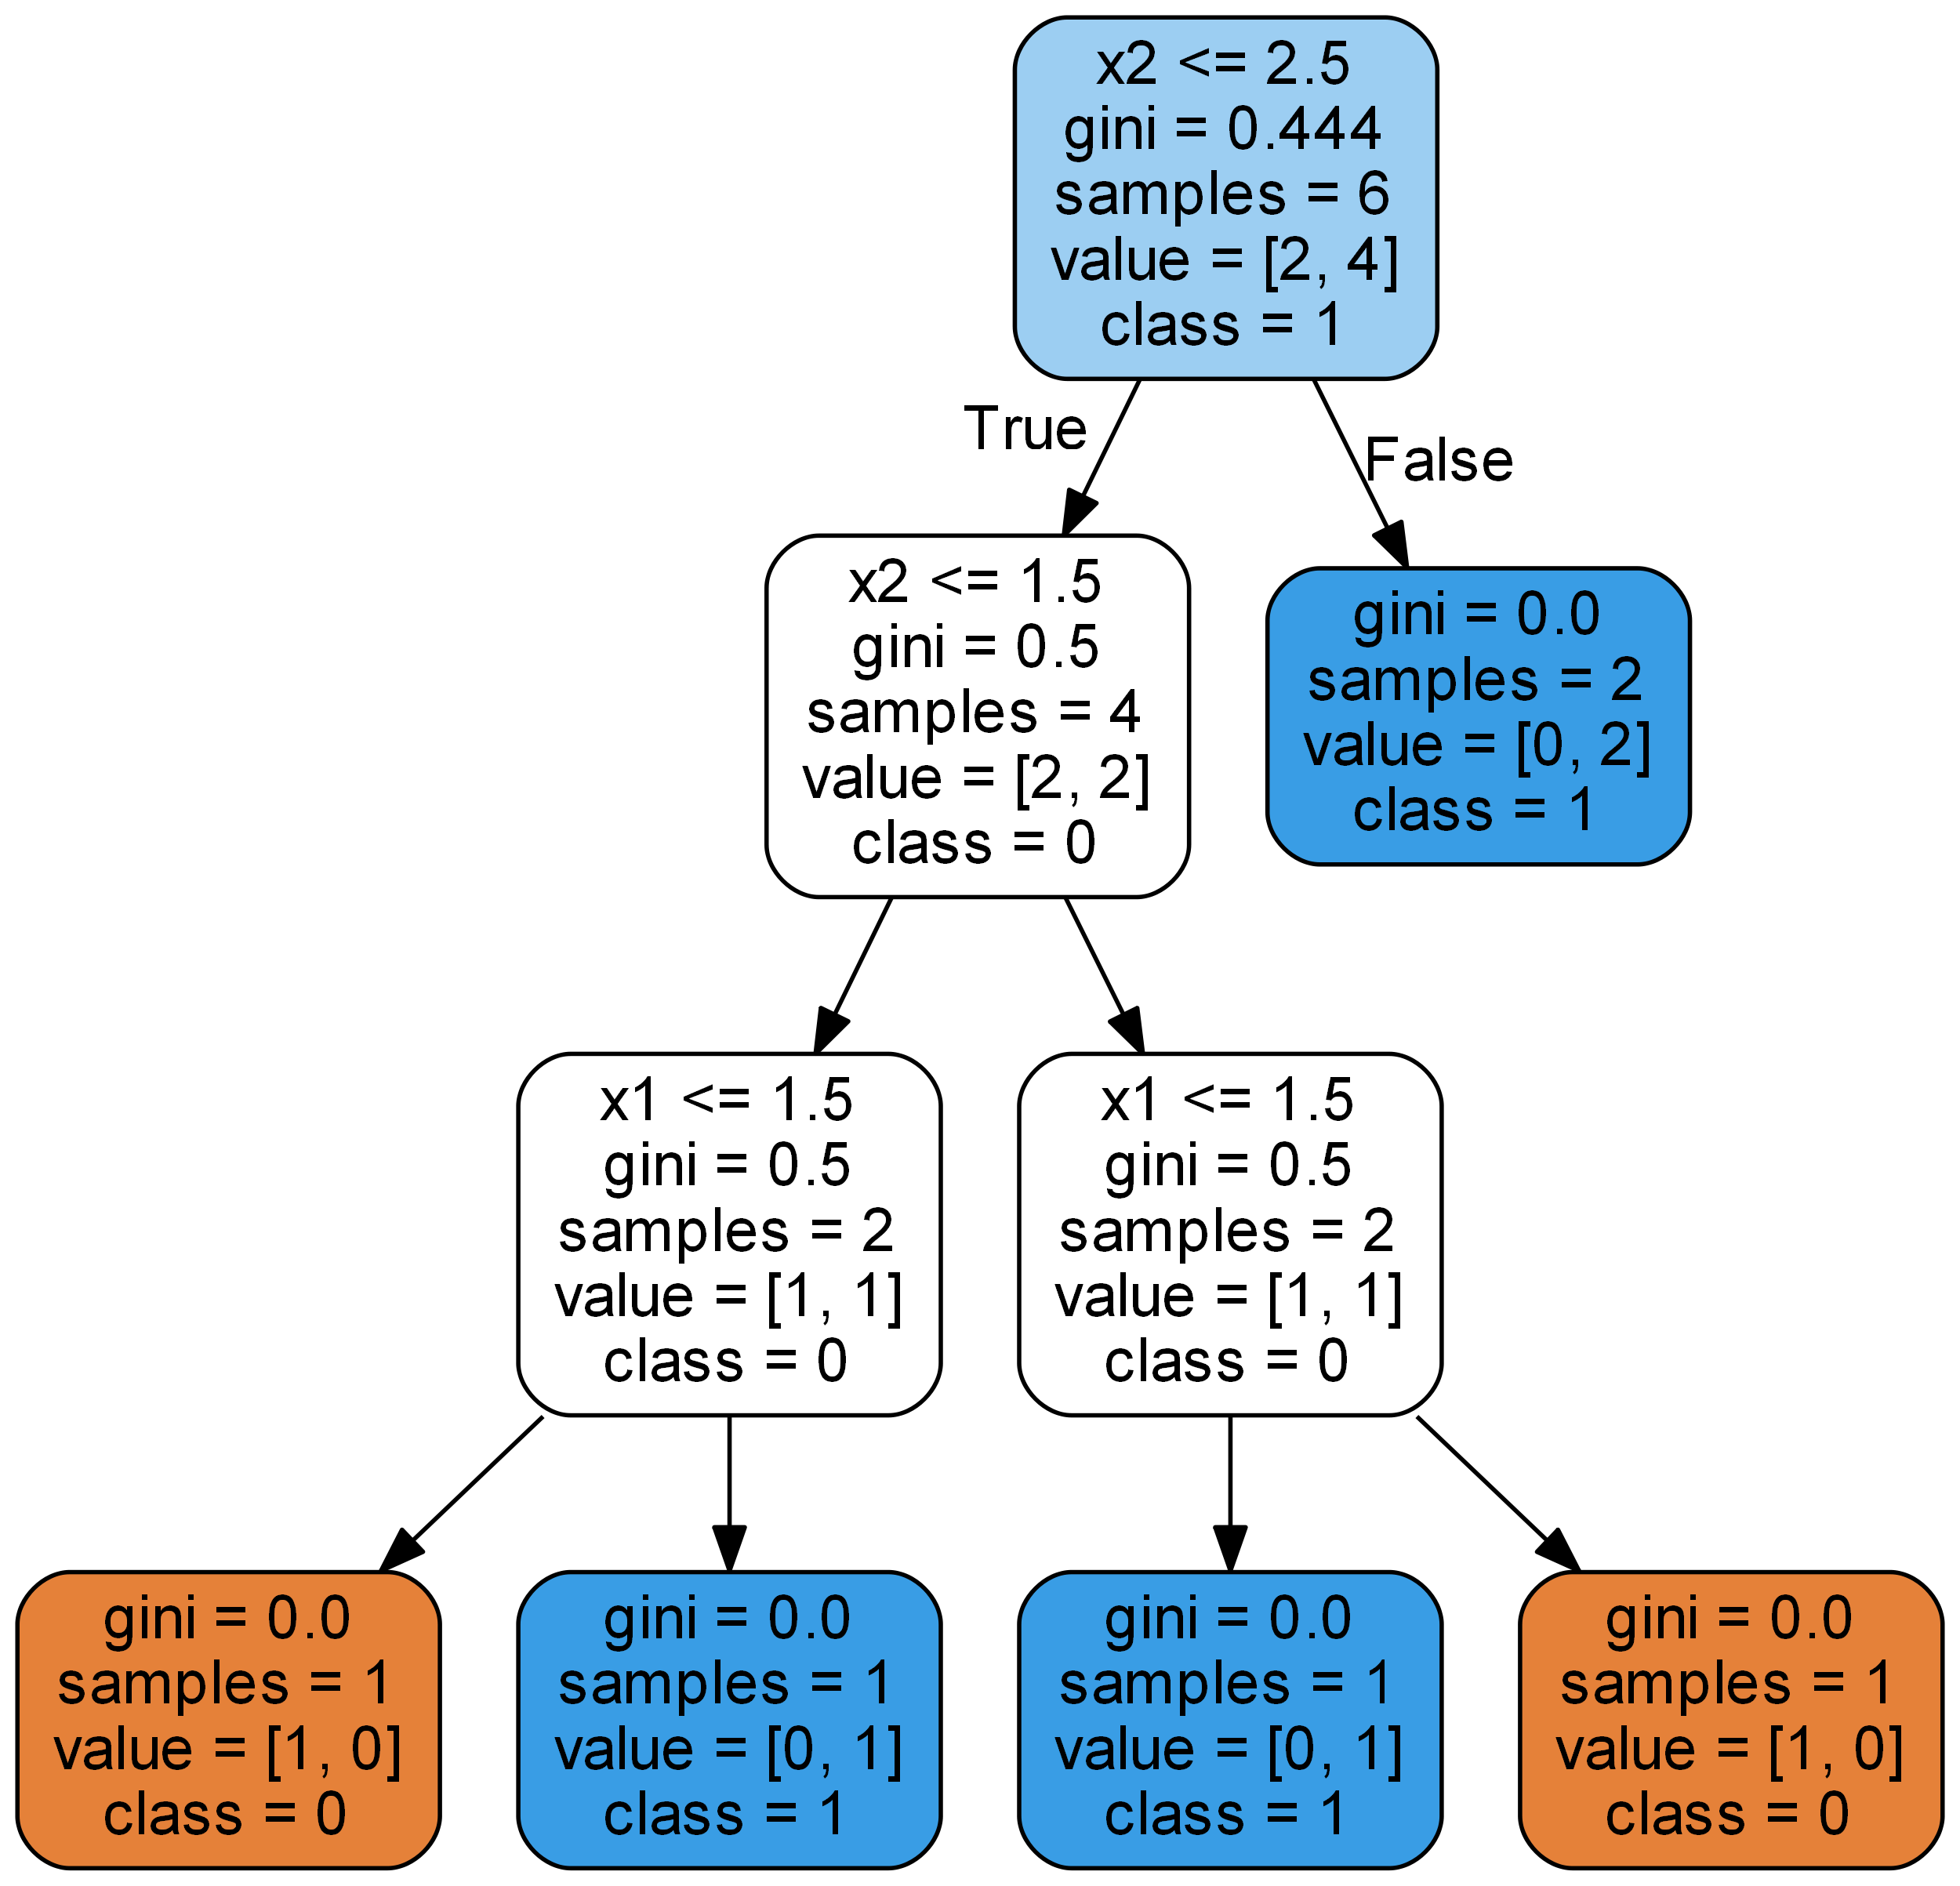

In [33]:
from IPython.display import Image
Image('tree.png')

决策树是一个直观的模型：它通过构建一个问题的流程图来做决策，就像我们在面对一个问题时一样。对于每个节点（叶子节点除外），这五行表示如下：
1. 关于基于特征的数据的判断：这决定了遍历树以获取新数据点的方式
2. `gini`:节点的基尼系数，平均(按样本加权)基尼系数随着树节点的下降而减少。
3. `sample`:节点中的观察样本数量
4. `value`:[第一类中的样本数，第二类中的样本数]
5. `class`:该节点中的大多数点的分类，如果是叶子节点，则是对节点内样本的预测(如果两类一样多则为0)
叶子结点（每个分支的终端结点）不再判断，因为它们是树进行预测的地方。一个叶子节点中的所有样本都被分配到同一个类别。

### 基尼系数

基尼系数表示根据节点中的样本分布，从节点中随机选择的样本被错误分类的概率。在顶部，有44.4%的机会，随机选择的点会被错误地分类。基尼系数是决策树如何进行分割的。它根据降低基尼不纯度最大的特征值来分割样本。 如果我们做数学计算，平均（按样本数加权）的基尼系数会随着我们在树上的移动而减少。
最终，随着我们对每个点的正确分类，平均基尼系数上升到0.0。然而，正确地对每一个训练点进行分类通常不是一个好的指标，因为这意味着模型将无法归纳到测试数据中去 这个模型对每一个训练点都进行了正确的分类，因为我们没有限制最大深度，而且在训练过程中，我们给了模型答案和特征。

### 限制最大深度

在实际中，我们通常希望限制决策树的最大深度（即使是在随机森林中），以便决策树能够更好地归纳到测试数据。虽然这将导致训练数据的准确性降低，但它可以提高测试数据的性能。

In [34]:
# 限制最大深度并训练
short_tree = DecisionTreeClassifier(max_depth = 2, random_state=RSEED)
short_tree.fit(X, y)

print(f'Model Accuracy: {short_tree.score(X, y)}')

Model Accuracy: 0.6666666666666666


我们可以像以前一样，将整个决策树可视化。

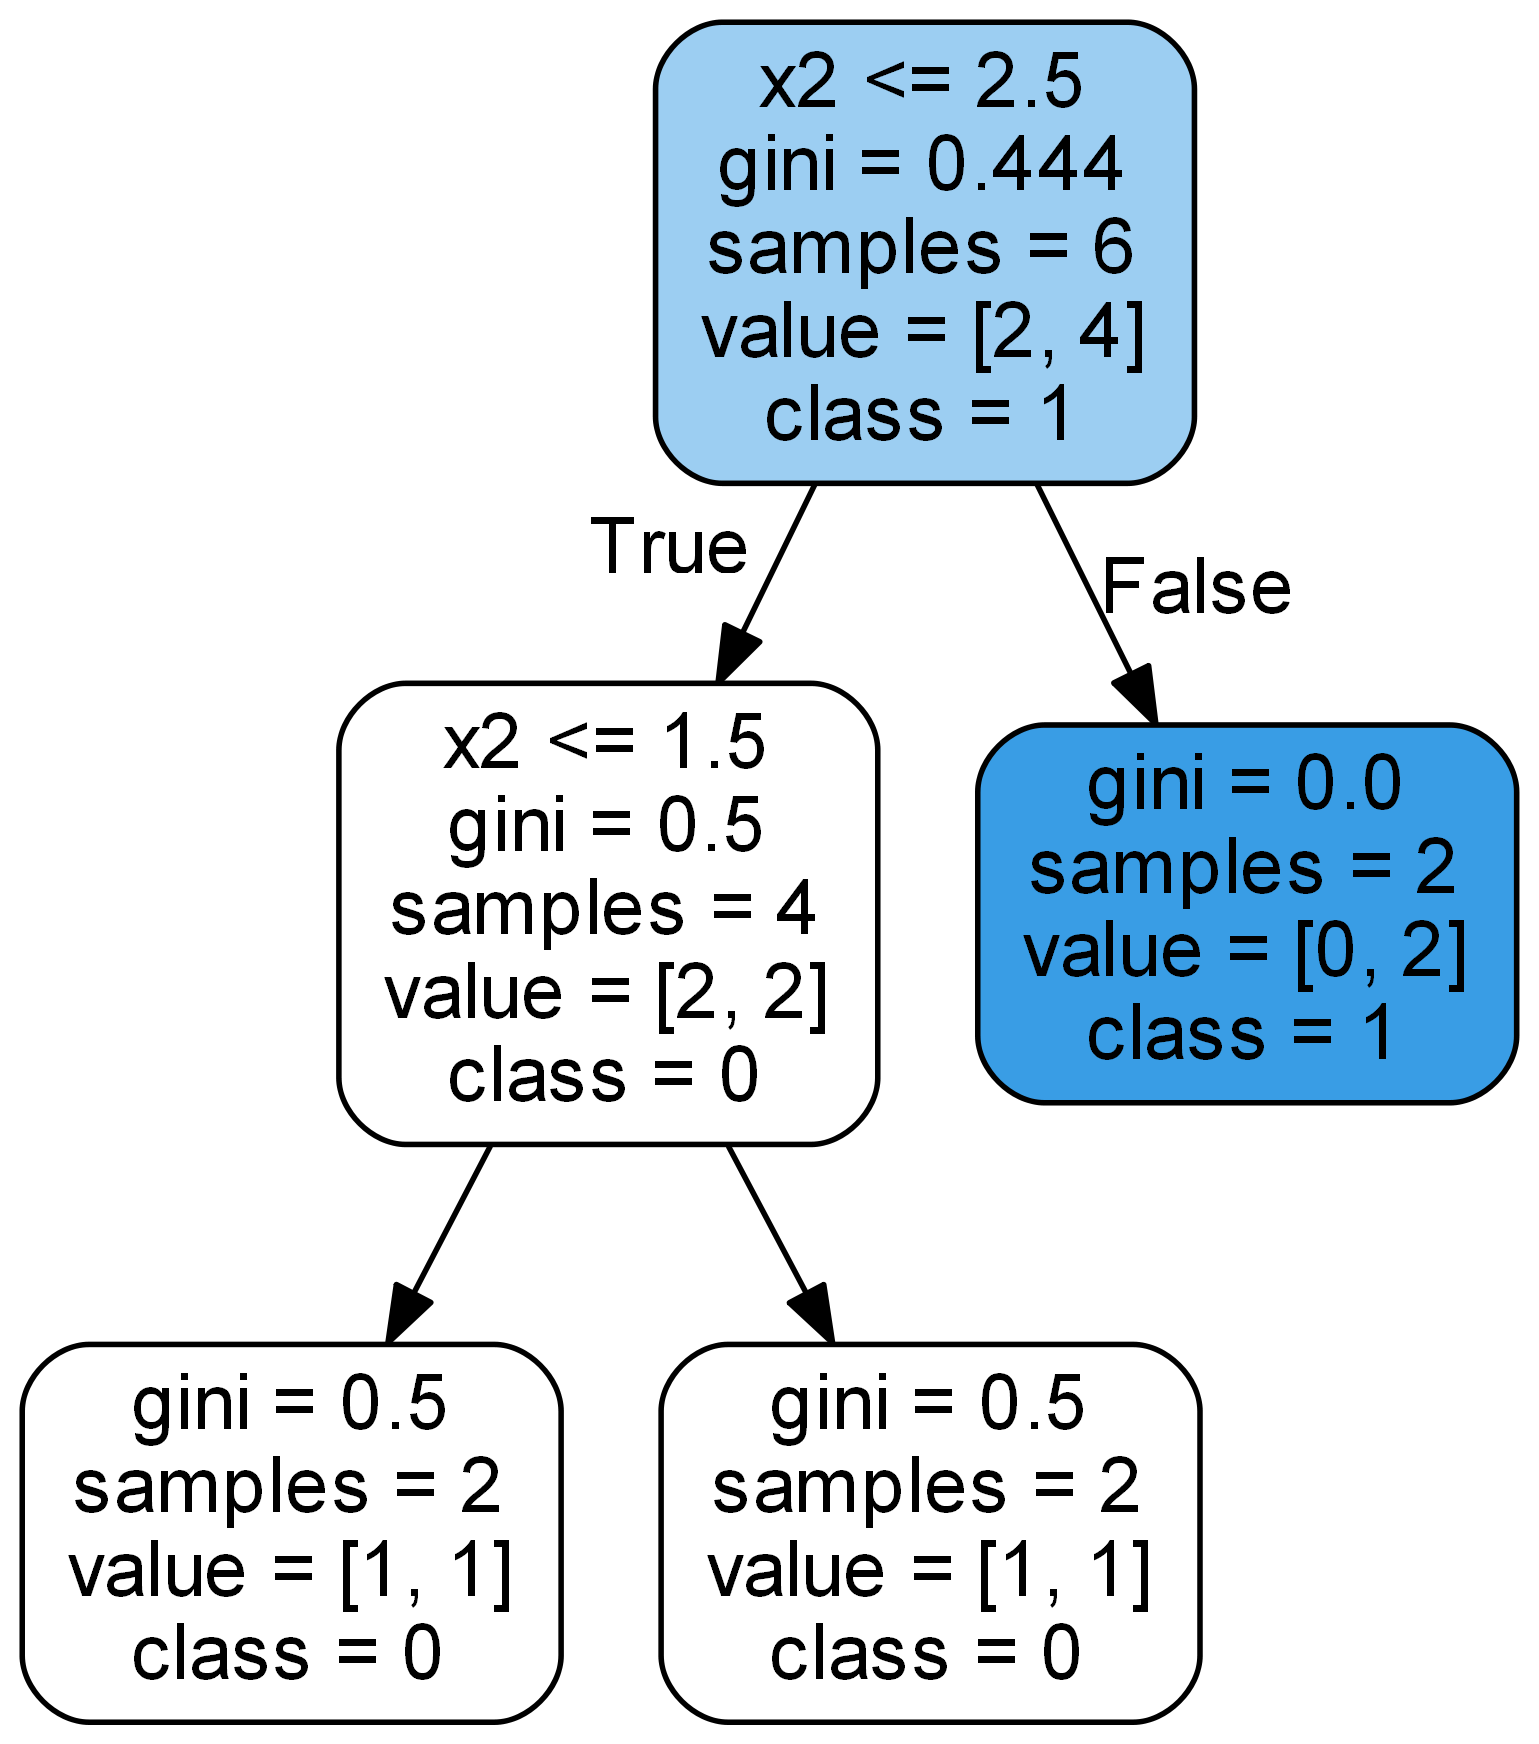

In [35]:
# 导出为dot
export_graphviz(short_tree, 'shorttree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)
cmd = 'dot -Tpng shorttree.dot -o shorttree.png -Gdpi=400'
os.system(cmd)
Image('shorttree.png')

我们的模型在训练数据上不再获得完美的准确性。然而，它在测试数据上可能会做得更好，因为我们已经限制了最大深度以防止过度拟合。这是机器学习中偏见-方差权衡的一个例子。一个具有高方差的模型对训练数据学习得非常好，但往往不能对测试集中的新点进行归纳。另一方面，一个高偏差的模型没有很好地学习训练数据，因为它没有足够的复杂性。这种模型在新的点上也不会有好的表现。

限制单个决策树的深度是我们可以尝试制作一个偏差较小的模型的一种方法。另一个选择是使用整个树的森林，在训练数据的一个随机子样本上训练每一个。然后，最终的模型采用所有单独的决策树的平均值来得出分类结果。这就是随机森林背后的想法。

希望这个简单的例子能让你了解决策树是如何进行分类的。它查看特征和标签，并试图构建一个问题流程图，最终为每个标签做出正确的分类。如果我们不限制树的深度，它可以对训练数据中的每一个点进行正确分类。不过这将导致过度拟合，无法在测试数据上做得很好。在这个例子中，我们没有任何测试数据，但在下一个问题中，我们使用了一个真实世界的数据集，我们将看到过度拟合是如何成为一个问题的!

# 真实数据集

[数据来源 kaggle](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

以下数据集来自美国疾病控制和预防中心（CDC），包括数十万人的社会经济和生活方式指标。其目的是预测个人的整体健康状况：0代表健康状况不佳，1代表健康状况良好。我们将数据限制在10万个个体，以加快训练速度。  

这个问题是不平衡的（一种标签远多于另一种标签），所以为了评估性能，我们将使用召回率、精确度、接收器操作特征曲线下的面积（ROC AUC），并且还绘制ROC曲线。在处理不平衡的问题时，准确度不是一个有用的指标。

## 数据处理
我们将读入数据并做一些处理

In [38]:
#sample 随机选取100000个数据
df = pd.read_csv('data/2015.csv').sample(100000, random_state = RSEED)
df.head()

_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
383119    49.0     4.0  b'05192015'  b'05'  b'19'  b'2015'    1100.0   
55536      9.0     9.0  b'09232015'  b'09'  b'23'  b'2015'    1100.0   
267093    34.0    10.0  b'11052015'  b'11'  b'05'  b'2015'    1100.0   
319092    41.0     4.0  b'04062015'  b'04'  b'06'  b'2015'    1100.0   
420978    54.0     5.0  b'05112015'  b'05'  b'11'  b'2015'    1100.0   

               SEQNO          _PSU  CTELENUM  ...  _PAREC1  _PASTAE1  \
383119  2.015009e+09  2.015009e+09       NaN  ...      4.0       2.0   
55536   2.015005e+09  2.015005e+09       1.0  ...      2.0       2.0   
267093  2.015011e+09  2.015011e+09       NaN  ...      4.0       2.0   
319092  2.015002e+09  2.015002e+09       1.0  ...      2.0       2.0   
420978  2.015004e+09  2.015004e+09       NaN  ...      1.0       1.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
383119       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
55536        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
267093       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
319092       2.0       2.0       3.0       1.0       1.0       2.0       1.0   
420978       3.0       3.0       4.0       1.0       1.0       NaN       NaN   

        _AIDTST3  
383119       2.0  
55536        2.0  
267093       2.0  
319092       2.0  
420978       2.0  

[5 rows x 330 columns]

In [39]:
#选出所有数值型的列
df = df.select_dtypes('number')
df.head()

_STATE  FMONTH  DISPCODE         SEQNO          _PSU  CTELENUM  \
383119    49.0     4.0    1100.0  2.015009e+09  2.015009e+09       NaN   
55536      9.0     9.0    1100.0  2.015005e+09  2.015005e+09       1.0   
267093    34.0    10.0    1100.0  2.015011e+09  2.015011e+09       NaN   
319092    41.0     4.0    1100.0  2.015002e+09  2.015002e+09       1.0   
420978    54.0     5.0    1100.0  2.015004e+09  2.015004e+09       NaN   

        PVTRESD1  COLGHOUS  STATERES  CELLFON3  ...  _PAREC1  _PASTAE1  \
383119       NaN       NaN       NaN       NaN  ...      4.0       2.0   
55536        1.0       NaN       1.0       1.0  ...      2.0       2.0   
267093       NaN       NaN       NaN       NaN  ...      4.0       2.0   
319092       1.0       NaN       1.0       1.0  ...      2.0       2.0   
420978       NaN       NaN       NaN       NaN  ...      1.0       1.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
383119       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
55536        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
267093       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
319092       2.0       2.0       3.0       1.0       1.0       2.0       1.0   
420978       3.0       3.0       4.0       1.0       1.0       NaN       NaN   

        _AIDTST3  
383119       2.0  
55536        2.0  
267093       2.0  
319092       2.0  
420978       2.0  

[5 rows x 323 columns]

### 分配标签

In [40]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

1.0    81140
0.0    18579
Name: label, dtype: int64

标签不平衡意味着准确度不是最好的指标。

我们不会在本notebook中进行任何数据探索，但通常情况下，探索数据是最佳实践。这可以帮助您进行功能工程(我们在这里也不会这样做)，或者通过识别和纠正数据中的异常/错误。

下面，我们删除了一些不应该用于建模的列(它们是标签的不同版本)。

In [41]:
# 删除缺失列的数据
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## 将数据分成训练集和测试集
为了评估我们的预测，我们需要使用训练集和测试集。该模型从训练数据中学习，然后对测试数据进行预测。因为我们有测试数据的正确答案，所以我们可以判断模型对新数据的泛化能力有多好。重要的是只使用一次测试集，因为这是对模型在新数据上的执行情况的估计。

我们将保留30%的示例用于测试。

In [42]:
from sklearn.model_selection import train_test_split

# 去除标签
labels = np.array(df.pop('label'))

# 30%的样本作为测试数据
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [43]:
df.head()

_STATE  FMONTH  DISPCODE         SEQNO          _PSU  CTELENUM  \
383119    49.0     4.0    1100.0  2.015009e+09  2.015009e+09       NaN   
55536      9.0     9.0    1100.0  2.015005e+09  2.015005e+09       1.0   
267093    34.0    10.0    1100.0  2.015011e+09  2.015011e+09       NaN   
319092    41.0     4.0    1100.0  2.015002e+09  2.015002e+09       1.0   
420978    54.0     5.0    1100.0  2.015004e+09  2.015004e+09       NaN   

        PVTRESD1  COLGHOUS  STATERES  CELLFON3  ...  _PAREC1  _PASTAE1  \
383119       NaN       NaN       NaN       NaN  ...      4.0       2.0   
55536        1.0       NaN       1.0       1.0  ...      2.0       2.0   
267093       NaN       NaN       NaN       NaN  ...      4.0       2.0   
319092       1.0       NaN       1.0       1.0  ...      2.0       2.0   
420978       NaN       NaN       NaN       NaN  ...      1.0       1.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
383119       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
55536        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
267093       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
319092       2.0       2.0       3.0       1.0       1.0       2.0       1.0   
420978       3.0       3.0       4.0       1.0       1.0       NaN       NaN   

        _AIDTST3  
383119       2.0  
55536        2.0  
267093       2.0  
319092       2.0  
420978       2.0  

[5 rows x 313 columns]

#### 缺失值填充
我们将用该列的平均值来填补缺失值。值得注意的是，我们用训练数据中各列的平均值来填补测试集的缺失值。这是必要的，因为如果我们得到新的数据，我们将不得不使用训练数据来填补任何缺失的值。

In [44]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances特征重要性
features = list(train.columns)

In [45]:
train.shape

(69803, 313)

In [46]:
test.shape

(29916, 313)

## 真实数据的决策树

首先，我们要在数据上训练决策树。我们让深度不受限制，看看是否会出现过拟合的情况!

In [47]:
# 训练
tree.fit(train, train_labels)
print(f'决策树有 {tree.tree_.node_count} 个节点，最大深度为 {tree.tree_.max_depth}.')

决策树有 12327 个节点，最大深度为 55.


## 评估决策树的表现

考虑到决策树中的节点数和最大深度，我们期望它对训练数据过拟合。
这意味着它在训练数据上比在测试数据上做得更好。

In [48]:
# 进行概率预测
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [57]:
predictions

array([1., 1., 0., ..., 1., 1., 1.])

In [55]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'训练的 ROC AUC : {roc_auc_score(train_labels, train_probs)}')
print(f'测试的 ROC AUC : {roc_auc_score(test_labels, probs)}')

训练的 ROC AUC : 1.0
测试的 ROC AUC : 0.6639639045644772


In [28]:
print(f'基本Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

基本Baseline ROC AUC: 0.5


我们的模型确实优于基线猜测，但我们可以看到它对训练数据进行了严重的过度拟合，获得了完美的 ROC AUC。

## 评估决策树

我们将编写一个简短的函数，计算基线（猜测训练数据中最常见的标签）、测试预测和训练预测的一些指标。该函数还绘制了ROC曲线，其中更好的模型在左边，朝上的模型在右边

In [29]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [56]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 23139, 0.0: 6777})
Counter({1.0: 23139, 0.0: 6777})


Recall Baseline: 1.0 Test: 0.83 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.66 Train: 1.0


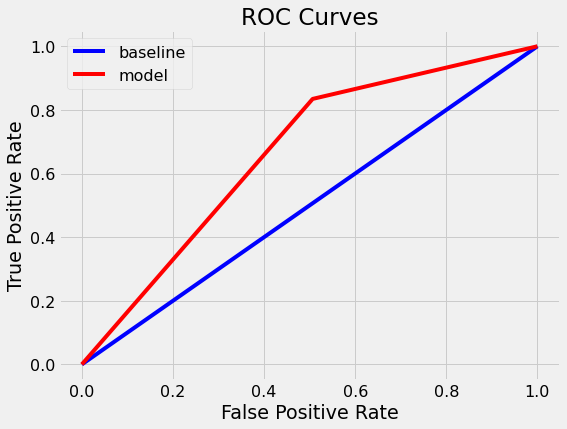

In [31]:
evaluate_model(predictions, probs, train_predictions, train_probs)

在这里，我们可以看到最大深度不受限制的单一决策树的问题。__对训练数据严重过拟合__。

另一种检查分类模型性能的方法是做一个误差矩阵。

### 误差矩阵

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2750  2824]
 [ 4027 20315]]


D:\Anaconda3\envs\sklearn\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


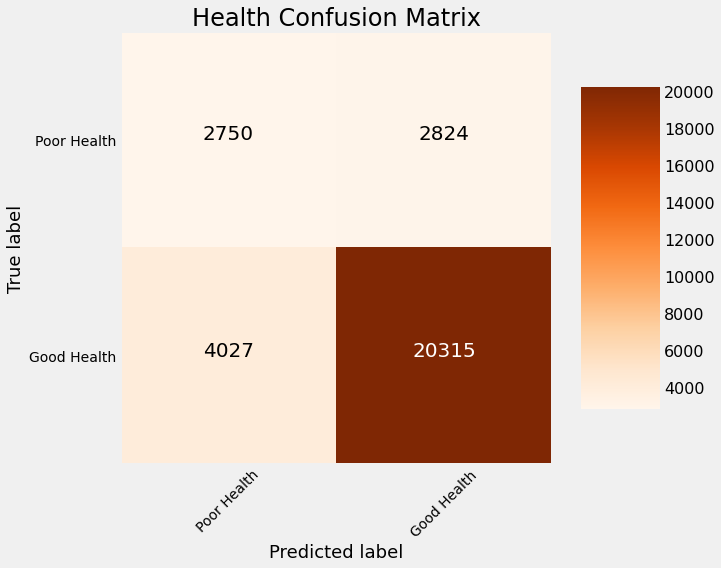

In [33]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

这显示了模型在测试数据上预测的分类，以及真实的标签。我们可以看到，我们的模型有许多假阴性（预测健康状况良好但实际上健康状况不佳）和假阳性（预测健康状况不佳但实际上健康状况良好）。

### 特征的重要性

最后，我们可以看一下决策树认为最重要的特征。这些值是通过对使用该特征的树的所有节点上的基尼系数减少量的总和计算出来的。

In [34]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

feature  importance
62   DIFFWALK    0.191702
58   QLACTLM2    0.030550
51    EMPLOY1    0.023743
64   DIFFALON    0.018419
245     _BMI5    0.016785

我们在此不详述其定义，但你可以通过[数据字典](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system#2015_formats.json)来确定每个特征的含义。

### 可视化整个树

和以前一样，我们可以看一下数据上的决策树。这一次，我们必须限制最大深度，否则树就会过大，无法转换和显示为图像。

In [35]:
# Save tree as dot file
export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
cmd = 'dot -Tpng tree_real_data.dot -o tree_real_data.png -Gdpi=200'
os.system(cmd)
# Visualize
Image(filename='tree_real_data.png')

我们可以看到，我们的模型非常深，有很多节点。为了减少我们模型的方差，我们可以限制最大深度或叶子节点的数量。另一种减少方差的方法是使用更多的树，每一棵树都是在观察值的随机抽样上训练出来的。这就是随机森林开始发挥作用的地方。

# 随机森林

现在我们可以进入一个更强大的模型，即随机森林。它采用了单一决策树的概念，并从数百或数千棵树中创建一个集合模型，以减少差异。每棵树都是在观察的随机集合上训练的，对于一个节点的每个分割，只有一个特征子集被用来进行分割。在进行预测时，随机森林对每个数据点的每个单独的决策树的预测进行平均，以得出最终的分类结果。

在Scikit-Learn中创建和训练随机森林是非常容易的。下面的单元格就是你所需要的一切。

In [36]:
from sklearn.ensemble import RandomForestClassifier

# 创建100个树的模型
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

我们可以看到每棵树平均有多少个节点，以及每棵树的最大深度。森林中共有100棵树。

In [37]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


我们看到，森林中的每棵决策树都有很多节点，而且非常深。然而，即使每个单独的决策树可能对训练数据的特定子集过度拟合，但我们的想法是，整个随机森林应该有一个降低的方差。

## 随机森林结果

In [38]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


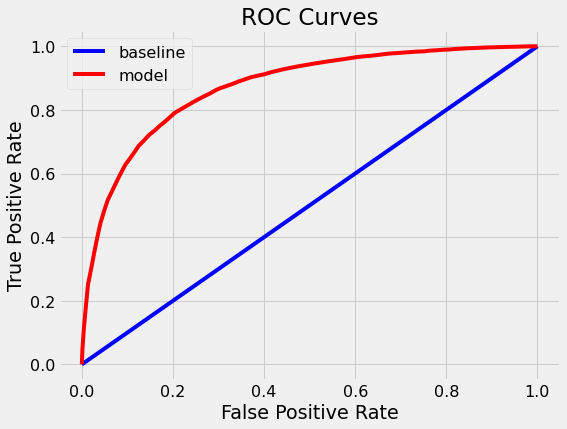

In [39]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

该模型在训练数据上仍然达到了完美的衡量标准，但这一次，测试的分数要好得多。如果我们比较ROC的AUC，我们会发现随机森林的表现明显好于单一的决策树。

Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


D:\Anaconda3\envs\sklearn\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


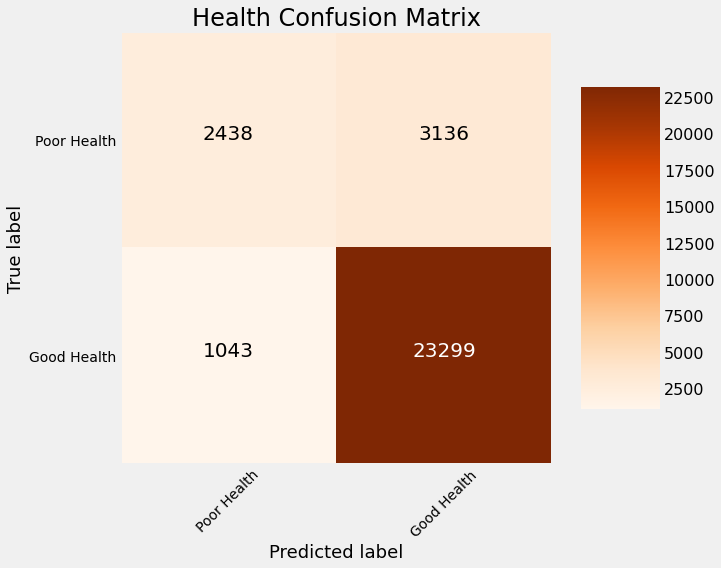

In [40]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

与单一决策树相比，该模型的假阳性较少，但假阴性较多。__总的来说，随机森林的表现明显优于单一决策树__。

这正是我们所期望的!

In [41]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

feature  importance
62   DIFFWALK    0.036200
58   QLACTLM2    0.030694
51    EMPLOY1    0.024156
64   DIFFALON    0.022699
59   USEEQUIP    0.016922
61     DECIDE    0.016271
307  _LMTSCL1    0.013424
53    INCOME2    0.011929
37   CHCCOPD1    0.011506
245     _BMI5    0.011497

我们的模型做得很好! 与单一决策树相比，随机森林对新数据的归纳能力要好得多。

# 通过随机搜索优化随机森林

为了使随机森林的性能最大化，我们可以进行随机搜索，寻找更好的超参数。这将从一个网格中随机选择超参数的组合，在训练数据上使用交叉验证对它们进行评估，并返回表现最好的值。

In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [43]:
rs.best_params_

{'n_estimators': 29,
 'min_samples_split': 5,
 'max_leaf_nodes': 43,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': True}

我们可以看到，最佳的超参数值并不是默认值。这表明为特定的数据集调整模型的重要性。每个数据集都有不同的特点，在一个数据集上表现最好的模型不一定在所有数据集上都表现最好。

### 使用最佳模型

现在我们可以把最好的模型（它已经被训练过了）拿出来评估。希望它比现有的随机森林做得更好。

In [44]:
best_model = rs.best_estimator_

In [45]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [46]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 85
Average maximum depth 10


正如我们在上面看到的，最佳的最大深度并不是无限的! 这表明，限制单个决策树的最大深度可以提高随机森林的交叉验证性能。

Recall Baseline: 1.0 Test: 0.97 Train: 0.98
Precision Baseline: 0.81 Test: 0.86 Train: 0.87
Roc Baseline: 0.5 Test: 0.87 Train: 0.88


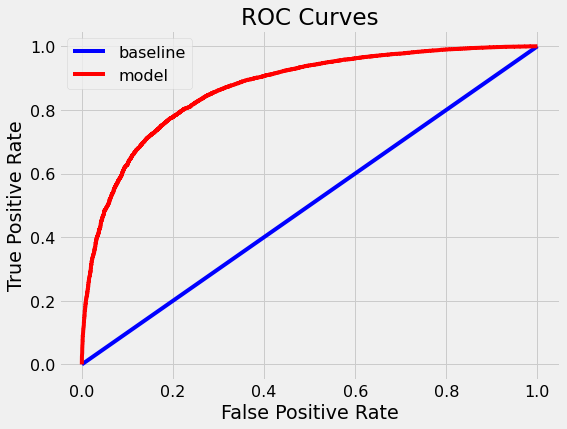

In [47]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

优化后的模型实现了与默认模型差不多的性能。更多的随机搜索迭代可以提高性能，也有可能我们已经接近随机森林在这个问题上所能达到的极限了。

In [52]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

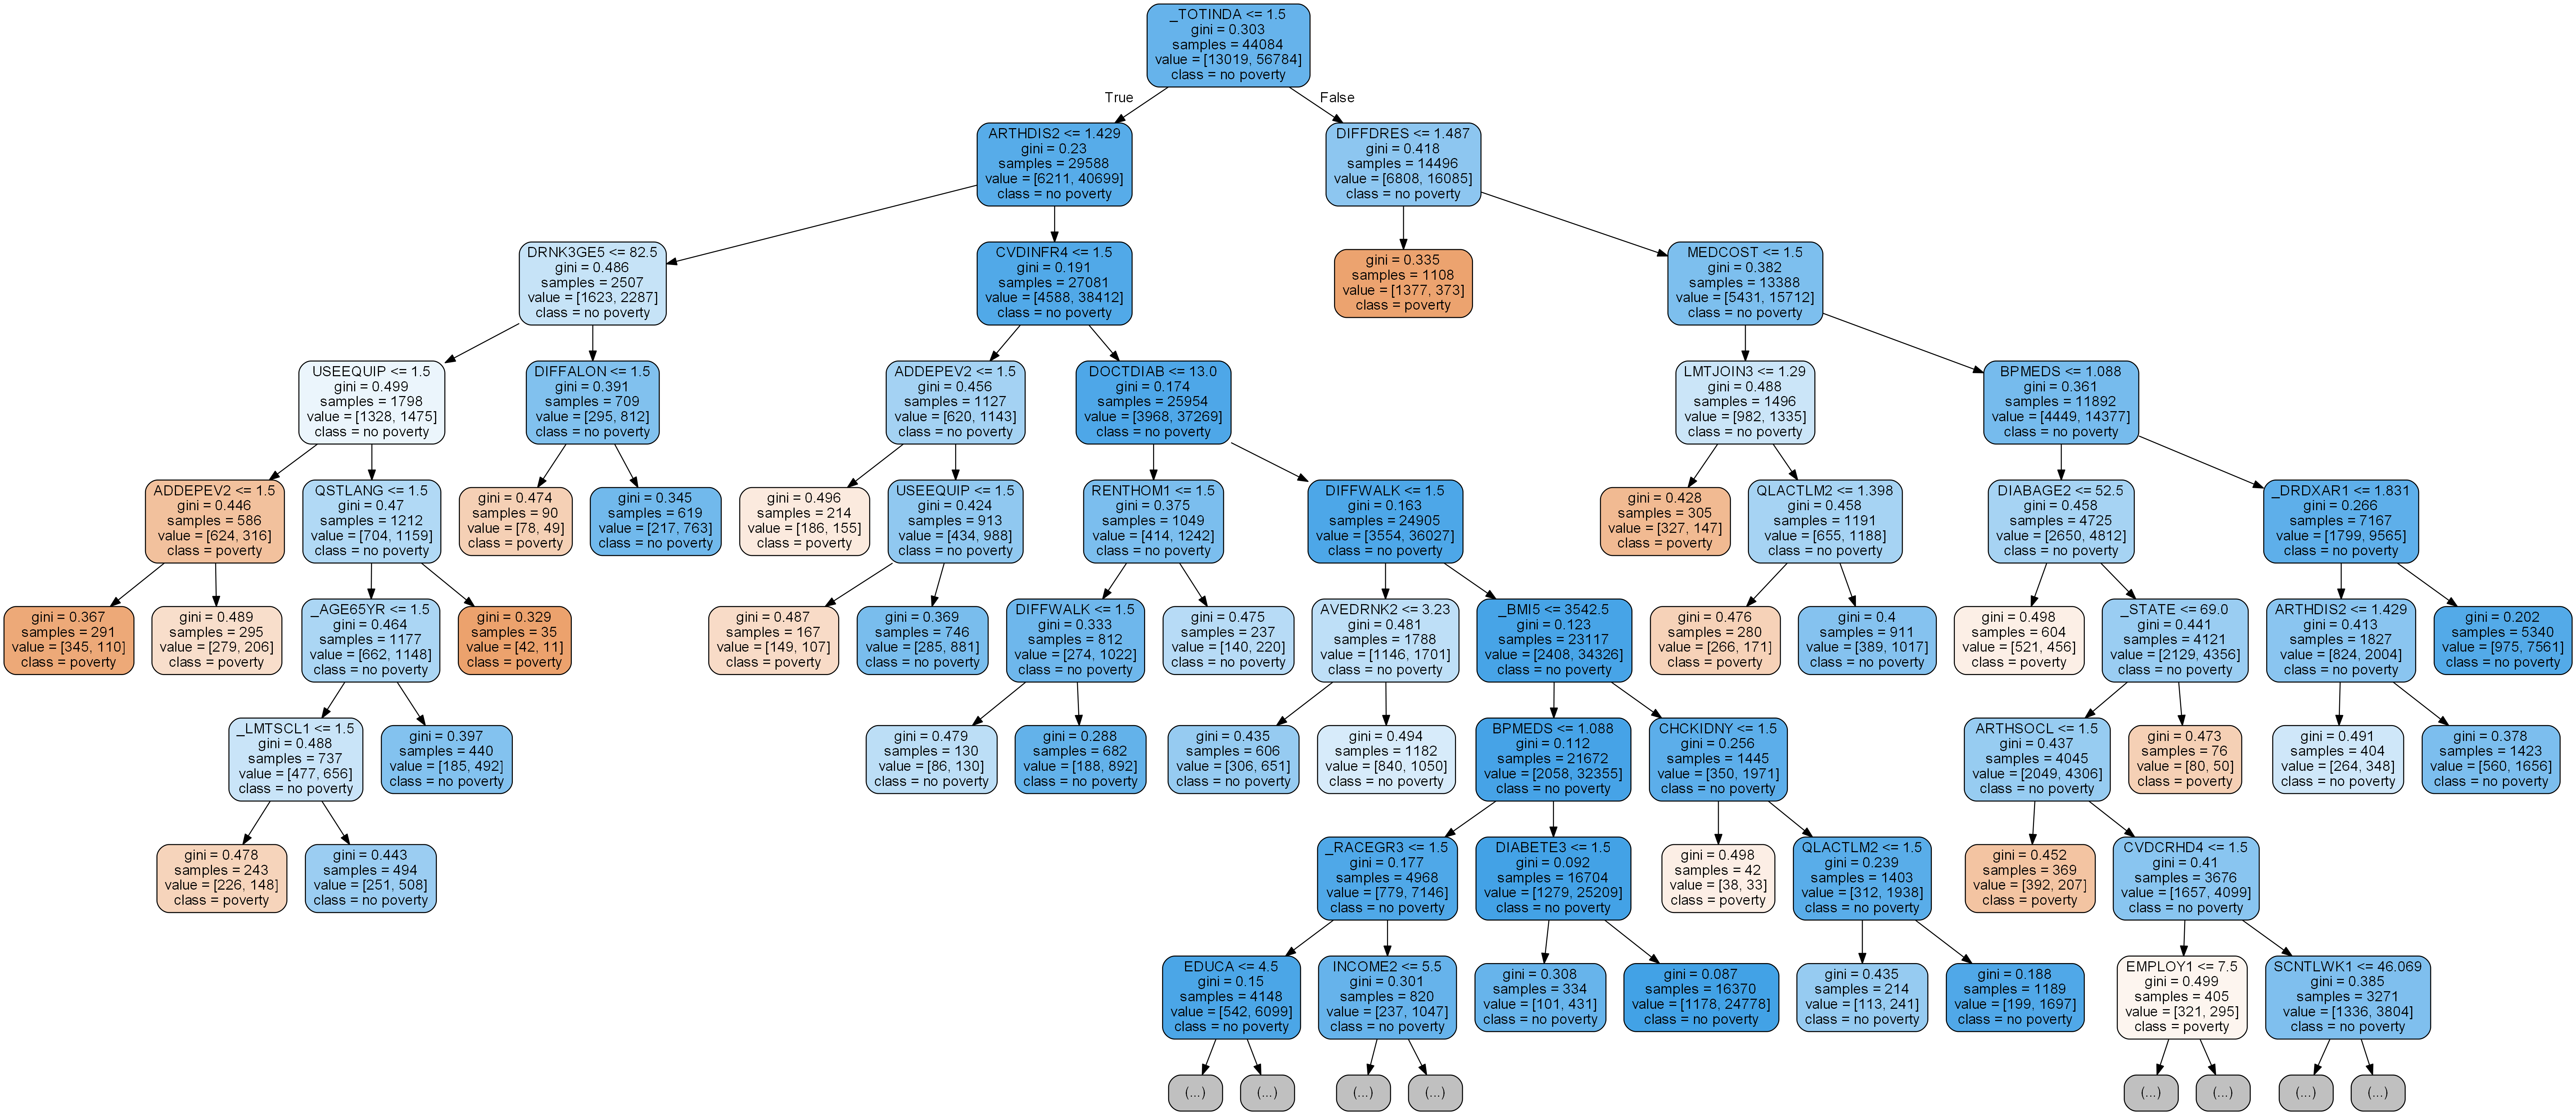

In [55]:
cmd = 'dot -Tpng tree_from_optimized_forest.dot -o tree_from_optimized_forest.png -Gdpi=200'
os.system(cmd)
Image('tree_from_optimized_forest.png')

这种树比单独的决策树模型要简单一些。随机搜索发现，限制森林中树的最大深度比让它们根据需要扩展提供更好的性能。

# 结论

在这个notebook中，我们用Python建立并使用了一个随机森林机器学习模型。我们不是只写代码而不理解模型，而是通过检查单个决策树和讨论其局限性来形成对随机森林的理解。我们将决策树可视化，看它是如何做出决策的，也看到了一棵决策树是如何过度适应训练数据的。__为了克服单个决策树的局限性，我们可以在一个单一的集合模型中训练数百或数千个决策树。这个模型被称为随机森林，在不同的训练观察数据集上训练每一棵树，并在每个节点上根据特征的子集进行分割，导致模型的方差减少，在测试集上有更好的泛化性能。__

需要掌握的关键概念是
1. 单个决策树：直观的模型，根据对特征值提出的问题的流程图做出决定。具有高变异性，表示对训练数据的过度拟合。
2. 基尼系数。决策树在拆分每个节点时试图最小化的措施。代表从一个节点中随机选择的样本根据该节点中的样本分布而被不完全分类的概率。
3. Bootstrapping：用替换法对观察值的随机集进行抽样。随机森林用于训练每个决策树的方法。
4. 特征的随机子集：在考虑如何分割决策树中的每个节点时，选择一个随机的特征集。
5. 随机森林：由数百或数千棵决策树组成的集合模型，使用自举、特征的随机子集和平均投票来进行预测。 
6. 偏差-变异权衡：机器学习中的基本问题，描述了高复杂度的模型与简单模型之间的权衡，前者能很好地学习训练数据，但代价是不能泛化到测试数据（高变异），后者甚至不能学习训练数据（高偏差）。随机森林减少了单一决策树的方差，同时也准确地学习了训练数据，从而对测试数据做出了更好的预测。

希望这本notebook不仅为你提供了使用随机森林所需的代码，还为你提供了理解模型如何进行决策所需的背景。机器学习是一个强大的工具，不仅要知道如何使用这个工具，而且要了解它是如何工作的！这一点很重要。